In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

### Чтение данных

In [2]:
source_file = 'data/train/2ao_2rs_2902231044.csv'

In [3]:
# Читаем файл с данными траекторий
data = pd.read_csv(source_file)

# Указываем сортировку данных - сначала по ID РЛС, затем - по внутреннему (внутри РЛС) ID ВО и по времени
data = data.sort_values(by=['rs_id', 'id', 'time']).reset_index(drop=True)

# Очищаем данные от NaN значений (первые строки каждой траектории без оценок скорости и ускорения)
data = data.drop(columns=['load_time']).dropna()

In [4]:
data

,rs_id,id,time,x,y,z,x_err,y_err,z_err,v_x_est,v_y_est,v_z_est,a_x_est,a_y_est,a_z_est
2,0,0,20,62.794263,999.944349,10000.024246,0.1,0.1,0.1,3.132710,0.002766,-0.004957,-0.002040,0.000853,-0.000931
3,0,0,30,94.183851,999.999129,10000.035915,0.1,0.1,0.1,3.138959,0.005478,0.001167,0.000625,0.000271,0.000612
4,0,0,40,125.618293,999.934375,9999.950345,0.1,0.1,0.1,3.143444,-0.006475,-0.008557,0.000449,-0.001195,-0.000972
5,0,0,50,156.964688,1000.098654,10000.055478,0.1,0.1,0.1,3.134640,0.016428,0.010513,-0.000880,0.002290,0.001907
6,0,0,60,188.397909,999.987322,10000.048285,0.1,0.1,0.1,3.143322,-0.011133,-0.000719,0.000868,-0.002756,-0.001123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239999,1,1,599960,-125.555623,0.046976,10000.008674,0.1,0.1,0.1,3.143833,-0.005146,-0.006217,-0.000019,-0.001933,-0.000603
240000,1,1,599970,-94.322911,-0.097716,9999.967717,0.1,0.1,0.1,3.123271,-0.014469,-0.004096,-0.002056,-0.000932,0.000212
240001,1,1,599980,-62.831442,0.000980,10000.092361,0.1,0.1,0.1,3.149147,0.009870,0.012464,0.002588,0.002434,0.001656
240002,1,1,599990,-31.468821,0.033288,10000.002752,0.1,0.1,0.1,3.136262,0.003231,-0.008961,-0.001288,-0.000664,-0.002143


### Реализация FCM

### Обучение FCM

### Тестирование FCM

In [9]:
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


dtype = torch.float64

CLUSTER_DATA = './'  # folder where the data sets are stored


class FuzzyCluster(torch.nn.Module):
    '''
        This does fuzzy c-means clustering, maintaining a set of centroids.
        It is packaged as a torch Module, so the forward pass
        re-calculates the partition matrix based on the supplied data.
        Alternate this with recalc_centroids to do the clustering.
        Can optionally register the entroids as parameters and learn them.
    '''

    _EPS = 1e-12  # Value to use instead of 0 (to prevent div-by-zero)

    def __init__(self, n_c, n_in, m=1.7):
        '''
            n_c is the number of clusters
            n_in is the number of input features
            m is the weighting parameter, controls the amount of fuzziness
        '''
        super(FuzzyCluster, self).__init__()
        self.n_c = n_c
        self.n_in = n_in
        self.m = m
        self.centroids = torch.rand((self.n_c, self.n_in), dtype=dtype)
        self.last_u = None  # Record the most recent partition matrix

    def set_centroids(self, new_centroids):
        self.centroids = new_centroids

    def register_centroids(self):
        '''
            Call this to register the centroids as torch parameters,
            so we can (afterwards) use backprop to learn them.
        '''
        init_centroids = self.centroids
        del self.centroids  # Delete the version that's not a Torch parameter
        self.register_parameter('centroids',
                                torch.nn.Parameter(init_centroids))

    @staticmethod
    def _cdist(x1, x2):
        '''
            Pairwise distances between two sets of points
            - this mimics the scipy function spatial.distance.cdist
            Source: https://github.com/pytorch/pytorch/issues/15253
        '''
        x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
        x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
        # res = x2^2 -2(x1 @ x2) + x1^2
        res = torch.addmm(x2_norm.transpose(-2, -1),
                          x1, x2.transpose(-2, -1),
                          alpha=-2).add_(x1_norm)
        res = res.sqrt().clamp_min(FuzzyCluster._EPS)
        return res

    def recalc_centroids(self, x, u):
        '''
            Re-calculate the positions of the centroids for each cluster.
                x.shape = n_cases * n_in
                u.shape = n_cases * self.n_c
            Returns the new centroids (but does not update them):
                v.shape = self.n_c * n_in
        '''
        um = u ** self.m
        # Batch multiply um by v:
        v = torch.einsum('mi,mj->ij', um, x)
        # Divide by u^m, summed by clusters:
        v /= um.sum(dim=0).clamp_min_(FuzzyCluster._EPS).unsqueeze(1)
        return v

    def forward(self, x):
        ''' Calculate and return the partition matrix u,
            which shows (for each x) its membership degree of each cluster
            x.shape = n_cases * n_in
            u.shape = n_cases * self.n_c
        '''
        d = FuzzyCluster._cdist(x, self.centroids)
        u = d ** (- 2. / (self.m - 1))
        self.last_u = u / u.sum(dim=1, keepdim=True)
        return self.last_u


def plot_clusters(x, fc):
    u = fc(x)
    num_clusters = u.shape[1]
    # Hardening: assign each point to cluster with maximum membership:
    crisp_clusters = u.argmax(dim=1)
    # Pick a different color for the points in each cluster:
    all_colors = sns.color_palette("hls", num_clusters)
    pt_colors = [all_colors[i] for i in crisp_clusters]
    # Plot clusters and then centroids:
    plt.figure(1)
    plt.scatter(x[:, 0], x[:, 1], s=1, color=pt_colors)
    centroids = fc.centroids.detach().numpy()
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=175, color='black')


def evaluate_clustering(dataset, fc):
    '''
        Compute the fuzzy partition coefficient from u.
        This measures the degree of fuzziness
    '''
    x = dataset.tensors[0]
    u = fc(x)
    trace = torch.einsum('ij,ji->', u, u.t())
    return trace / u.shape[0]


def cmeans_cluster(dataset, num_clusters, max_epochs=250, show_plots=True):
    '''
        Cluster the x data into num_clusters clusters, optionally plot.
        Will execute up to max_epochs, unless centroids stabilise.
        Returns the FuzzyCluster object (contains centroids, partition)
    '''
    MIN_CHANGE = 1e-5  # This is what I mean by "stabilise"
    x = dataset.tensors[0]
    n_in = x.shape[1]
    fc = FuzzyCluster(num_clusters, n_in)
    print('### Training for up to {} epochs, size = {} cases'.
          format(max_epochs, x.shape[0]))
    for t in range(max_epochs):
        u = fc(x)
        new_centroids = fc.recalc_centroids(x, u)
        delta_v = F.l1_loss(new_centroids, fc.centroids)
        fc.set_centroids(new_centroids)
        if max_epochs < 30 or t % 10 == 0:
            print('Epoch {:3d}, change={:.5f}, fuzziness={:.5f}'
                  .format(t, delta_v.item(),
                          evaluate_clustering(dataset, fc)))
        if delta_v < MIN_CHANGE:
            break
    if show_plots:
        plot_clusters(x, fc)
    return fc


def sgd_cluster(dataset, num_clusters, epochs=250, show_plots=True):
    '''
        Cluster the given data into the given number of clusters,
        but use stochastic gradient descent (SGD) and mini-batches.
        Always run for the given number of epochs.
    '''
    BATCH_SIZE = 1024
    data = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    n_in = dataset.tensors[0].shape[1]
    fc = FuzzyCluster(num_clusters, n_in)
    fc.register_centroids()
    optimizer = torch.optim.SGD(fc.parameters(), lr=1e-1, momentum=0.99)
    print('### Training for {} epochs, size = {} cases, batches of {}'.
          format(epochs, dataset.tensors[0].shape[0], BATCH_SIZE))
    for t in range(epochs):
        old_centroids = fc.centroids.clone()
        # Process each mini-batch in turn:
        for x, y_actual in data:
            u = fc(x)
            new_centroids = fc.recalc_centroids(x, u)
            optimizer.zero_grad()
            loss = F.mse_loss(fc.centroids, new_centroids)
            loss.backward()
            optimizer.step()
        # Epoch ending, so print progress for the whole batch:
        with torch.no_grad():
            delta_v = F.l1_loss(old_centroids, fc.centroids)
        if epochs < 30 or t % 10 == 0:
            print('Epoch {:3d}, change={:.5f}, fuzziness={:.5f}'
                  .format(t, delta_v.item(),
                          evaluate_clustering(dataset, fc)))
    # End of training, so graph the results:
    if show_plots:
        plot_clusters(dataset.tensors[0], fc)
    return fc


def read_data(filename, n_in=2):
    '''
        Read the x data points from the given file, one point per line;
        n_in is the number of input features (i.e. co-ords for each point).
        Optionally read the ground-truth categories if there.
        Return a dataset with two tensors: (points, ground-truths)
    '''
    points = []
    truths = []  # i.e. the categories the points actually belong to
    pathname = os.path.join(CLUSTER_DATA, filename)
    with open(pathname, 'r') as fh:
        for line in fh:
            nums = [n for n in line.strip().split()]
            points.append([float(n) for n in nums[:n_in]])
            if len(nums) == n_in+1:
                truths.append(int(nums[n_in]))
    if len(truths) == 0:  # no ground truths supplied
        truths = [-1] * len(points)
    return TensorDataset(torch.tensor(points, dtype=dtype),
                         torch.tensor(truths, dtype=torch.long))


def read_and_cluster(filename, n_c, n_in=2):
    dataset = read_data(filename, n_in)
    fc = cmeans_cluster(dataset, n_c)
    evaluate_clustering(dataset, fc)
    return fc

### Training for up to 250 epochs, size = 600 cases
Epoch   0, change=9.35714, fuzziness=0.07129
Epoch  10, change=0.14559, fuzziness=0.81661
Epoch  20, change=0.00204, fuzziness=0.86448
Epoch  30, change=0.00630, fuzziness=0.86485
Epoch  40, change=0.00341, fuzziness=0.86491
Epoch  50, change=0.01464, fuzziness=0.92054


FuzzyCluster()

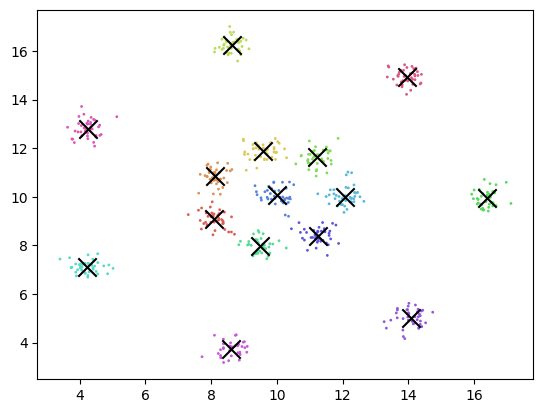

In [18]:
read_and_cluster('R15.txt', 15)